In [18]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
#без знания pandas и возможностей sklearn я не знаю как решить задачу
class CustomDataset(Dataset):
    def __init__(self, file_path, target_col, numerical_cols=None, categorical_cols=None, transform=True,
                sep = None):
        """
        :param file_path: путь к .csv файлу
        :param target_col: имя целевой переменной
        :param numerical_cols: список числовых признаков
        :param categorical_cols: список категориальных признаков
        :param transform: применять ли нормализацию и кодирование
        """
        self.data = pd.read_csv(file_path, sep=sep)
        
        self.target_col = target_col
        
        # Разделение признаков и целевой переменной
        self.features = self.data.drop(columns=[target_col])
        self.targets = self.data[target_col].values
        
        # Автоматическое определение типов признаков
        if numerical_cols is None and categorical_cols is None:
            numerical_cols = []
            categorical_cols = []
            for col in self.features.columns:
                if self.features[col].dtype == 'O' or len(self.features[col].unique()) < 20:
                    categorical_cols.append(col)
                else:
                    numerical_cols.append(col)
        self.numerical_cols = numerical_cols
        self.categorical_cols = categorical_cols
        # Преобразование данных
        self.transform = transform
        if transform:
            self._apply_transform()

    def _apply_transform(self):
        """
        Применяет нормализацию и one-hot кодирование
        """
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), self.numerical_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore'), self.categorical_cols)
            ],
            remainder='passthrough'
        )

        X_transformed = preprocessor.fit_transform(self.features)
        # Если матрица разреженная — переводим в плотный формат
        if hasattr(X_transformed, "toarray"):
            X_transformed = X_transformed.toarray()

        X_transformed = np.nan_to_num(X_transformed, nan=0.0, posinf=0.0, neginf=0.0)

        self.X_tensor = torch.tensor(X_transformed, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.targets, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.X_tensor[idx], self.y_tensor[idx]
        
def mse(y_pred: torch.Tensor, y_true:torch.Tensor) -> torch.Tensor:
    return ((y_pred - y_true)**2).mean()
        
def log_epoch(epoch, avg_loss, **metrics):
    message = f'Epoch: {epoch}\t loss:{avg_loss}'
    for k, v in metrics.items():
        message += f'\t{k}: {v:.4f}'
    print(message)

def accuracy(y_pred, y_true):
    y_pred_bin = (y_pred>0.5).float()
    return (y_pred_bin == y_true).float().mean().item()

In [4]:
import torch

class LinearRegressionTorch(torch.nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.linear = torch.nn.Linear(in_features, 1)
    
    def forward(self, x):
        return self.linear.forward(x)

In [5]:
import torch

class LogisticRegressionTorch(torch.nn.Module):
    def __init__(self, in_features, n_classes=1):
        super().__init__()
        self.linear = torch.nn.Linear(in_features, n_classes)
    
    def forward(self, x):
        return self.linear.forward(x)
    

In [6]:
url_linear = 'https://raw.githubusercontent.com/thainazanfolin/min_sleep_efficiency/refs/heads/main/Sleep_Efficiency_table.csv'
import kagglehub

url_logict = kagglehub.dataset_download("yasserh/titanic-dataset") #Взял все датасеты из своих наработок
#выбираем колонку по которой будем предиктить
# print(pd.read_csv(url_linear, sep=';'))
reg_dataset = CustomDataset(url_linear, target_col='Sleep efficiency', sep=';')

clf_dataset = CustomDataset(url_logict+'\\Titanic-Dataset.csv', target_col='Survived')

train_size_reg = int(0.8 * len(reg_dataset))
val_size_reg = len(reg_dataset) - train_size_reg
train_reg, val_reg = random_split(reg_dataset, [train_size_reg, val_size_reg])

train_loader_reg = DataLoader(train_reg, batch_size=32, shuffle=True)
val_loader_reg = DataLoader(val_reg, batch_size=32)

# То же самое для классификации
train_size_clf = int(0.8 * len(clf_dataset))
val_size_clf = len(clf_dataset) - train_size_clf
train_clf, val_clf = random_split(clf_dataset, [train_size_clf, val_size_clf])

train_loader_clf = DataLoader(train_clf, batch_size=32, shuffle=True)
val_loader_clf = DataLoader(val_clf, batch_size=32)

C:\Users\user\AppData\Local\Temp\ipykernel_9132\886287871.py:20: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  self.data = pd.read_csv(file_path, sep=sep)


# 3.1 Исследование гиперпараметров

In [19]:
def train_regression_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=100, early_stop=20):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    no_improvement = 0
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            y_pred = model(batch_x)
            loss = loss_fn(y_pred, batch_y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                y_pred = model(batch_x)
                loss = loss_fn(y_pred, batch_y)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= early_stop:
                break
    
    return train_losses, val_losses

In [20]:
def train_classification_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=100, early_stop=20):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    best_val_loss = float('inf')
    no_improvement = 0
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        total_train_acc = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            y_pred = model(batch_x)
            loss = loss_fn(y_pred, batch_y)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            preds = (torch.sigmoid(y_pred) > 0.5).float()
            total_train_acc += (preds == batch_y).float().mean().item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_acc = total_train_acc / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accs.append(avg_train_acc)
        
        model.eval()
        total_val_loss = 0
        total_val_acc = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                y_pred = model(batch_x)
                loss = loss_fn(y_pred, batch_y)
                total_val_loss += loss.item()
                preds = (torch.sigmoid(y_pred) > 0.5).float()
                total_val_acc += (preds == batch_y).float().mean().item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_acc = total_val_acc / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accs.append(avg_val_acc)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= early_stop:
                break
    
    return train_losses, val_losses, train_accs, val_accs

In [21]:
#Сделаю только для бинарной классификации, сложно как то для 1.5 часа решения домашки
def accuracy(y_pred, y_true): #вынес в отдельную функцию
    y_pred = (torch.sigmoid(y_pred) > 0.5).float()
    return (y_pred == y_true).float().mean().item()

def precision(y_pred, y_true):
    y_pred = (y_pred.sigmoid() > 0.5).float()#Применяем sigmoid, чтобы получить вероятности от 0 до 1
    #это случаи (tp), когда модель сказала да (y_pred == 1) и на самом деле - да (y_true == 1) 
    tp = (y_pred * y_true).sum().item()
    #это случаи (fp), когда модель сказала да (y_pred == 1), а на самом деле - нет (y_true == 0).
    fp = ((y_pred == 1) & (y_true == 0)).sum().item()
    if tp + fp == 0:
        return 0.0
    return tp / (tp + fp)

def recall(y_pred, y_true):
    y_pred = (y_pred.sigmoid() > 0.5).float()
    tp = (y_pred * y_true).sum().item()
    fn = ((y_pred == 0) & (y_true == 1)).sum().item()
    if tp + fn == 0:
        return 0.0
    return tp / (tp + fn)

def f1_score(y_pred, y_true):
    p = precision(y_pred, y_true)
    r = recall(y_pred, y_true)
    if p + r == 0:
        return 0.0
    return 2*p*r / (p + r) #изначально по формуле 2/(1/p + 1/r), но я раскрыл скобки просто

def roc_auc(y_pred, y_true):
    y_scores = y_pred.sigmoid().detach().numpy()#выход модели до sigmoid
    y_true = y_true.numpy()#реальные метки [0, 1]
    
    #cортировка по уверенности модели
    #мы делаем список пар (score, true_label) и сортируем его по убыванию уверенности модели.
    y_scores = y_scores.reshape(-1)  #делаем 1d (на случай, если пришёл 2d)
    y_true = y_true.reshape(-1)
    scores = np.column_stack((y_scores, y_true))  # связываем предсказания и правду
    scores = scores[scores[:, 0].argsort()][::-1]  # сортировка по убыванию уверенности
    
    #Общее число положительных и отрицательных примеров
    total_pos = y_true.sum()
    total_neg = len(y_true) - total_pos

    tp = fp = 0
    tpr_list = [0]
    fpr_list = [0]

    for score in scores:
        if score[1] == 1:
            tp += 1
        else:
            fp += 1
        tpr = tp / total_pos
        fpr = fp / total_neg
        tpr_list.append(tpr)
        fpr_list.append(fpr)

    #Вычисление площади под кривой (AUC)
    auc = 0
    for i in range(1, len(tpr_list)):
        #Интегрирование методом трапеций
        auc += (fpr_list[i] - fpr_list[i - 1]) * (tpr_list[i] + tpr_list[i - 1]) / 2

    return auc


def print_confusion_matrix(y_pred, y_true):
    y_pred = (torch.sigmoid(y_pred) > 0.5).float().numpy().flatten()# Преобразуем в numpy для удобства
    y_true = y_true.numpy().flatten()

    tp = np.sum((y_pred == 1) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))

    # Выводим confusion matrix
    print("Confusion Matrix:")
    print("               | Predicted Pos | Predicted Neg |")
    print("---------------|--------------|--------------|")
    print(f"Actual Pos     |     {tp:4d}    |     {fn:4d}    |")
    print(f"Actual Neg     |     {fp:4d}    |     {tn:4d}    |")
    print("\n")

    # Считаем метрики
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    # Выводим метрики
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    
# Визуализация результатов
def plot_results(df, x_col, y_cols, title, log_x=False):
    plt.figure(figsize=(12, 6))
    for y_col in y_cols:
        if log_x:
            plt.semilogx(df[x_col], df[y_col], marker='o', label=y_col)
        else:
            plt.plot(df[x_col], df[y_col], marker='o', label=y_col)
    plt.title(title)
    plt.xlabel(x_col)
    plt.legend()
    plt.grid(True)
    plt.show()


In [22]:
def experiment_learning_rate_regression():
    lrs = [0.001, 0.01, 0.1, 0.5, 1.0]
    results = []
    
    for lr in lrs:
        model = LinearRegressionTorch(reg_dataset.X_tensor.shape[1])
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        loss_fn = torch.nn.MSELoss()
        
        train_losses, val_losses = train_regression_model(
            model, train_loader_reg, val_loader_reg, optimizer, loss_fn, epochs=100
        )
        
        results.append({
            'lr': lr,
            'final_train_loss': train_losses[-1],
            'final_val_loss': val_losses[-1],
            'best_val_loss': min(val_losses),
            'epochs': len(train_losses)
        })
    
    return pd.DataFrame(results)

# Эксперименты с batch size для регрессии
def experiment_batch_size_regression():
    batch_sizes = [8, 16, 32, 64, 128]
    results = []
    
    for batch_size in batch_sizes:
        train_loader = DataLoader(train_reg, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_reg, batch_size=batch_size)
        
        model = LinearRegressionTorch(reg_dataset.X_tensor.shape[1])
        optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
        loss_fn = torch.nn.MSELoss()
        
        train_losses, val_losses = train_regression_model(
            model, train_loader, val_loader, optimizer, loss_fn, epochs=100
        )
        
        results.append({
            'batch_size': batch_size,
            'final_train_loss': train_losses[-1],
            'final_val_loss': val_losses[-1],
            'best_val_loss': min(val_losses),
            'epochs': len(train_losses)
        })
    
    return pd.DataFrame(results)

# Эксперименты с оптимизаторами для регрессии
def experiment_optimizers_regression():
    optimizers = {
        'SGD': torch.optim.SGD,
        'Adam': torch.optim.Adam,
        'RMSprop': torch.optim.RMSprop
    }
    results = []
    
    for name, opt_class in optimizers.items():
        model = LinearRegressionTorch(reg_dataset.X_tensor.shape[1])
        optimizer = opt_class(model.parameters(), lr=0.01)
        loss_fn = torch.nn.MSELoss()
        
        train_losses, val_losses = train_regression_model(
            model, train_loader_reg, val_loader_reg, optimizer, loss_fn, epochs=100
        )
        
        results.append({
            'optimizer': name,
            'final_train_loss': train_losses[-1],
            'final_val_loss': val_losses[-1],
            'best_val_loss': min(val_losses),
            'epochs': len(train_losses)
        })
    
    return pd.DataFrame(results)

# Эксперименты с learning rate для классификации
def experiment_learning_rate_classification():
    lrs = [0.001, 0.01, 0.1, 0.5, 1.0]
    results = []
    
    for lr in lrs:
        model = LogisticRegressionTorch(clf_dataset.X_tensor.shape[1])
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        loss_fn = torch.nn.BCEWithLogitsLoss()
        
        train_losses, val_losses, train_accs, val_accs = train_classification_model(
            model, train_loader_clf, val_loader_clf, optimizer, loss_fn, epochs=100
        )
        
        results.append({
            'lr': lr,
            'final_train_loss': train_losses[-1],
            'final_val_loss': val_losses[-1],
            'final_val_acc': val_accs[-1],
            'best_val_loss': min(val_losses),
            'best_val_acc': max(val_accs),
            'epochs': len(train_losses)
        })
    
    return pd.DataFrame(results)

# Эксперименты с batch size для классификации
def experiment_batch_size_classification():
    batch_sizes = [8, 16, 32, 64, 128]
    results = []
    
    for batch_size in batch_sizes:
        train_loader = DataLoader(train_clf, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_clf, batch_size=batch_size)
        
        model = LogisticRegressionTorch(clf_dataset.X_tensor.shape[1])
        optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
        loss_fn = torch.nn.BCEWithLogitsLoss()
        
        train_losses, val_losses, train_accs, val_accs = train_classification_model(
            model, train_loader, val_loader, optimizer, loss_fn, epochs=100
        )
        
        results.append({
            'batch_size': batch_size,
            'final_train_loss': train_losses[-1],
            'final_val_loss': val_losses[-1],
            'final_val_acc': val_accs[-1],
            'best_val_loss': min(val_losses),
            'best_val_acc': max(val_accs),
            'epochs': len(train_losses)
        })
    
    return pd.DataFrame(results)

# Эксперименты с оптимизаторами для классификации
def experiment_optimizers_classification():
    optimizers = {
        'SGD': torch.optim.SGD,
        'Adam': torch.optim.Adam,
        'RMSprop': torch.optim.RMSprop
    }
    results = []
    
    for name, opt_class in optimizers.items():
        model = LogisticRegressionTorch(clf_dataset.X_tensor.shape[1])
        optimizer = opt_class(model.parameters(), lr=0.01)
        loss_fn = torch.nn.BCEWithLogitsLoss()
        
        train_losses, val_losses, train_accs, val_accs = train_classification_model(
            model, train_loader_clf, val_loader_clf, optimizer, loss_fn, epochs=100
        )
        
        results.append({
            'optimizer': name,
            'final_train_loss': train_losses[-1],
            'final_val_loss': val_losses[-1],
            'final_val_acc': val_accs[-1],
            'best_val_loss': min(val_losses),
            'best_val_acc': max(val_accs),
            'epochs': len(train_losses)
        })
    
    return pd.DataFrame(results)


Running regression experiments...

Running classification experiments...


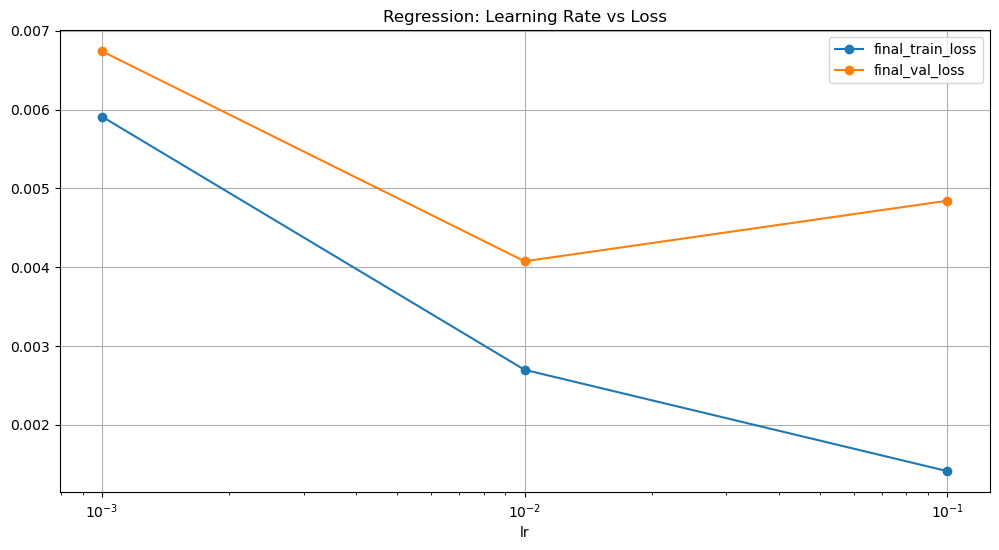

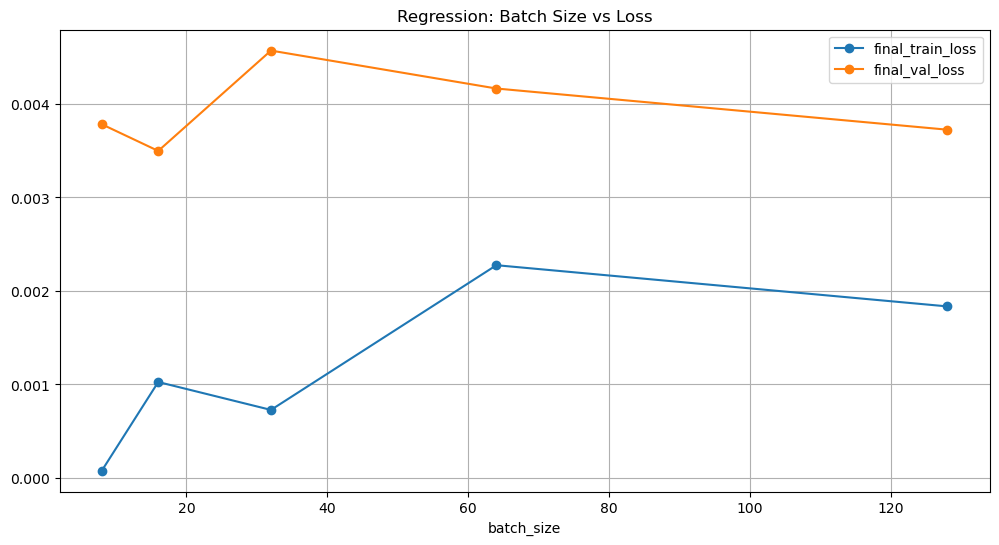

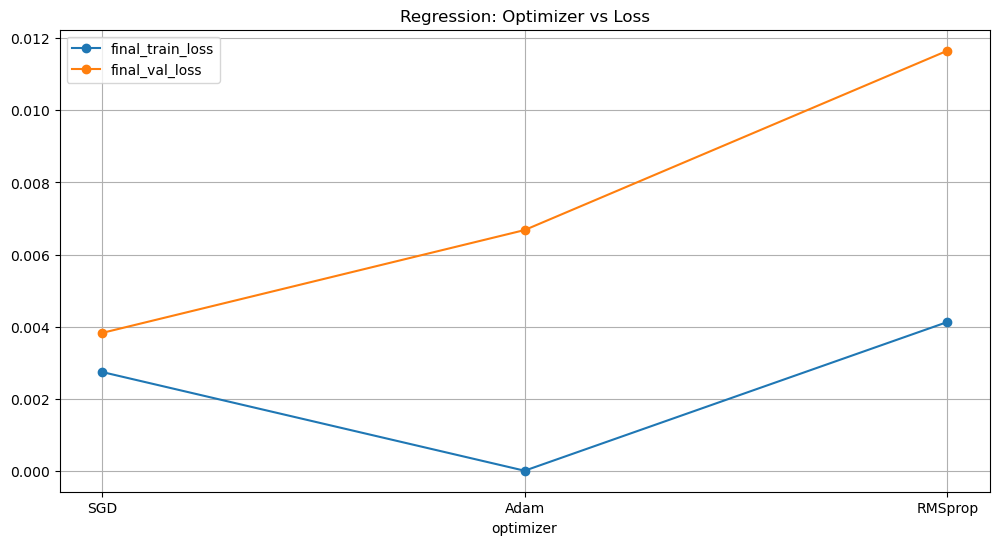

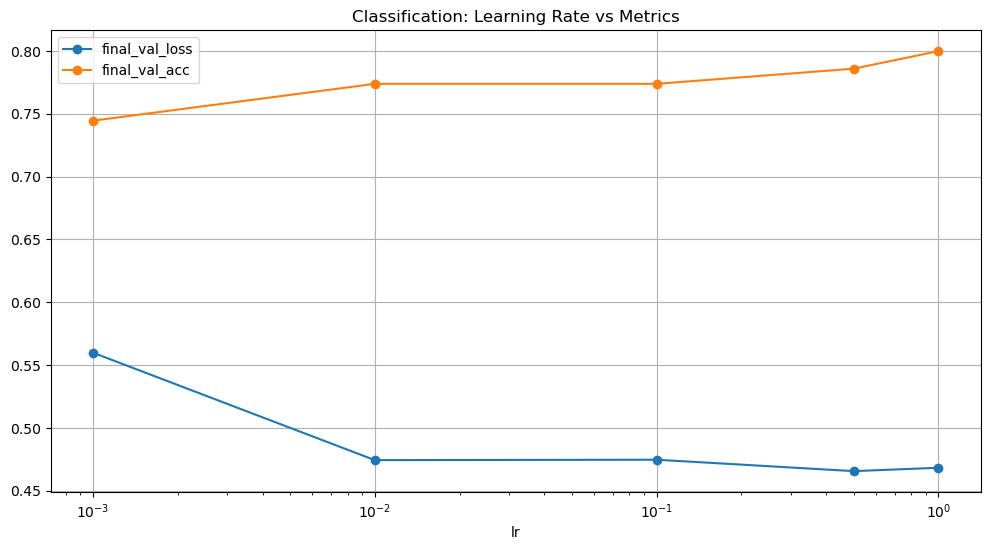

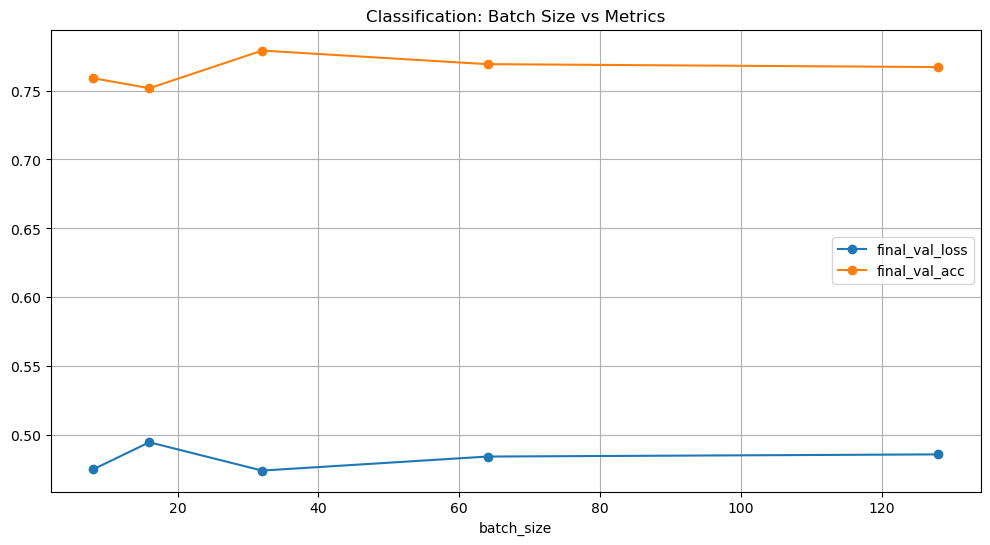

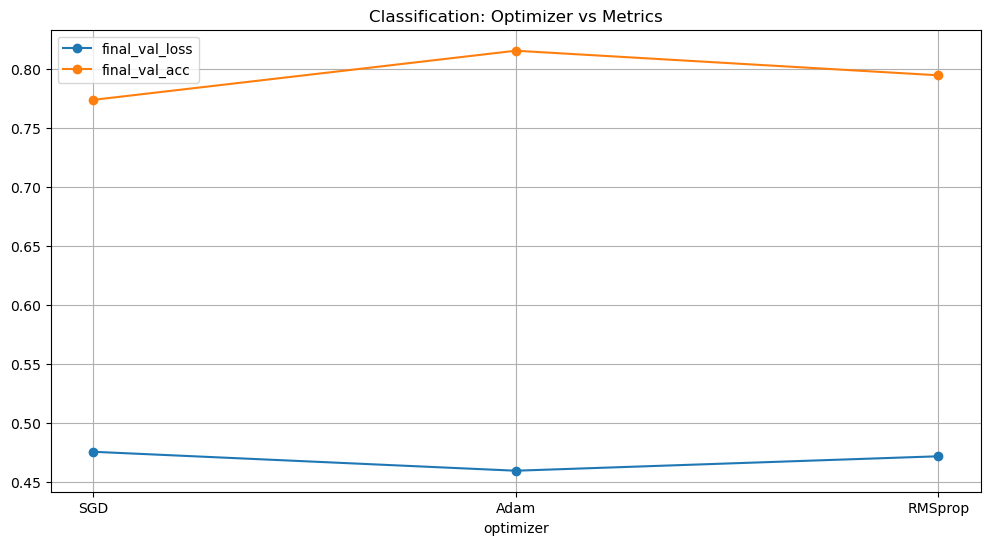


Regression Learning Rate Results:
      lr  final_train_loss  final_val_loss  best_val_loss  epochs
0  0.001          0.005911        0.006742   6.741610e-03     100
1  0.010          0.002697        0.004074   4.073828e-03     100
2  0.100          0.001411        0.004843   4.502123e-03      41
3  0.500               NaN             NaN   1.264652e+09      21
4  1.000               NaN             NaN   2.335788e+18      21

Regression Batch Size Results:
   batch_size  final_train_loss  final_val_loss  best_val_loss  epochs
0           8          0.000076        0.003782       0.003636      45
1          16          0.001024        0.003497       0.003278      26
2          32          0.000726        0.004571       0.004430      61
3          64          0.002274        0.004165       0.003901      36
4         128          0.001833        0.003724       0.003703     100

Regression Optimizer Results:
  optimizer  final_train_loss  final_val_loss  best_val_loss  epochs
0       SGD

In [23]:
# Запуск всех экспериментов и визуализация результатов
print("Running regression experiments...")
lr_reg_df = experiment_learning_rate_regression()
batch_reg_df = experiment_batch_size_regression()
opt_reg_df = experiment_optimizers_regression()

print("\nRunning classification experiments...")
lr_clf_df = experiment_learning_rate_classification()
batch_clf_df = experiment_batch_size_classification()
opt_clf_df = experiment_optimizers_classification()

# Визуализация результатов для регрессии
plot_results(lr_reg_df, 'lr', ['final_train_loss', 'final_val_loss'], 
            'Regression: Learning Rate vs Loss', log_x=True)
plot_results(batch_reg_df, 'batch_size', ['final_train_loss', 'final_val_loss'], 
            'Regression: Batch Size vs Loss')
plot_results(opt_reg_df, 'optimizer', ['final_train_loss', 'final_val_loss'], 
            'Regression: Optimizer vs Loss')

# Визуализация результатов для классификации
plot_results(lr_clf_df, 'lr', ['final_val_loss', 'final_val_acc'], 
            'Classification: Learning Rate vs Metrics', log_x=True)
plot_results(batch_clf_df, 'batch_size', ['final_val_loss', 'final_val_acc'], 
            'Classification: Batch Size vs Metrics')
plot_results(opt_clf_df, 'optimizer', ['final_val_loss', 'final_val_acc'], 
            'Classification: Optimizer vs Metrics')

# Вывод таблиц с результатами
print("\nRegression Learning Rate Results:")
print(lr_reg_df)

print("\nRegression Batch Size Results:")
print(batch_reg_df)

print("\nRegression Optimizer Results:")
print(opt_reg_df)

print("\nClassification Learning Rate Results:")
print(lr_clf_df)

print("\nClassification Batch Size Results:")
print(batch_clf_df)

print("\nClassification Optimizer Results:")
print(opt_clf_df)

# Интерпретация результатов
Learning rate:

Слишком маленький LR приведет к медленному обучению

Слишком большой LR может вызвать расходимость

Оптимальное значение обычно между 0.001 и 0.1

Batch size:

Маленькие батчи могут привести к более шумным градиентам

Большие батчи требуют больше памяти

Оптимальный размер обычно между 16 и 64

Оптимизаторы:

SGD прост, но может требовать тонкой настройки LR

Adam более адаптивен, но может хуже обобщаться

RMSprop - компромисс между SGD и Adam